In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import GenParamTuple# candidate_environments_args["n_environments"] = 50


np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

## Make true environment

In [2]:
# # 0. Setup
# N, M = 25, 25



# # Start by making the agent we want to learn the parameters of
# agent_gamma = np.array(0.76)
# p_true= np.array(0.85)
# big_reward_true = np.array(0.7)

# agent_R = np.zeros((N, M))
# agent_R[N-1, 0] = 0.1
# agent_R[N-1, M-1] = big_reward_true
# agent_R = agent_R.flatten()

# goal_states = np.where(agent_R != 0)[0]


# # wall_states = [14] #TODO: why do we need this
# wall_states = []

# T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
# T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)


# #Define custom functions to generate reward, transition and gamma.
# def custom_transition_func(p):

#     _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
#     _T = insert_walls_into_T(T=_T, wall_indices=wall_states)
#     return _T

# def custom_gamma_func(gamma):
#     return gamma

# def custom_reward_func(big_reward):
#     reward_func = np.zeros((N, M))
#     reward_func[N-1, 0] = 0.1
#     reward_func[0,M-1] = 0.2
#     reward_func[0,M-2] = -0.2
#     reward_func[N-1, M-1] = big_reward
#     return reward_func.flatten()


# #Create parameter ranges
# resolution = 20
# p_range = np.linspace(0.5, 0.95, resolution)
# gamma_range = np.linspace(0.5, 0.95, resolution)
# R_range = np.linspace(0.3, 0.95, resolution)


# gamma_range = gamma_range.reshape(1, resolution)
# p_range = p_range.reshape(1, resolution)
# R_range = R_range.reshape(1, resolution)

# p_true = p_true.reshape(1, 1)
# agent_gamma = agent_gamma.reshape(1, 1)
# big_reward_true = big_reward_true.reshape(1, 1)



# true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=big_reward_true)




# big_small = Environment(
#     N=N,
#     M=M,
#     reward_function = custom_reward_func,
#     transition_function=custom_transition_func,
#     gamma = custom_gamma_func,
#     wall_states=wall_states,
#     start_state=1,
#     goal_states=goal_states
# )

In [3]:
N, M = 5, 25

agent_gamma = np.array(0.7)
p_true= np.array(0.9)
reward_true = np.array(10)

agent_R = np.zeros((N, M))
agent_R[0,1:M-2] = -1
agent_R[0,M-1] = reward_true
agent_R = agent_R.flatten()

goal_states = np.where(agent_R != 0)[0]

#Define custom functions to generate reward, transition and gamma.
def custom_transition_func(p):

    _T = transition_matrix(N=N, M=M, p=p, absorbing_states=goal_states)
    return _T

def custom_gamma_func(gamma):
    return gamma

def custom_reward_func(reward):
    agent_R = np.zeros((N, M))
    agent_R[0,1:M-2] = -1
    agent_R[0,M-1] = reward
    return agent_R.flatten()

#Create parameter ranges
resolution = 15
p_range = np.linspace(0.7, 0.95, resolution)
gamma_range = np.linspace(0.7, 0.95, resolution)
R_range = np.linspace(0.7, 0.95, resolution)

gamma_range = gamma_range.reshape(1, resolution)
p_range = p_range.reshape(1, resolution)
R_range = R_range.reshape(1, resolution)



p_true = p_true.reshape(1, 1)
agent_gamma = agent_gamma.reshape(1, 1)
reward_true = reward_true.reshape(1, 1)



true_params = GenParamTuple(T = p_true, gamma=agent_gamma, R=reward_true)




cliff = Environment(
    N=N,
    M=M,
    reward_function = custom_reward_func,
    transition_function=custom_transition_func,
    gamma = custom_gamma_func,
    wall_states=[],
    start_state=0,
    goal_states=goal_states
)

In [7]:
env_design = EnvironmentDesign(base_environment=cliff, 
                               user_params=true_params, 
                               learn_what = ["gamma", "T"],
                               parameter_ranges_R=R_range,
                               parameter_ranges_gamma=gamma_range,
                               parameter_ranges_T=p_range)

Generated parameter mesh of shape:  (15, 15)


In [8]:
candidate_environments_args = {}
candidate_environments_args["generate_how"] = "AMBER"
candidate_environments_args["n_compute_BM"] = 100
candidate_environments_args["n_iterations"] = 1
candidate_environments_args["stepsize"] = 0.0005

# candidate_environments_args = {}
# candidate_environments_args["generate_how"] = "ED-BIRL"
# candidate_environments_args["n_environments"] = 1
# candidate_environments_args["n_walls"] = 5
# candidate_environments_args["how"] = "value"


env_design.run_n_episodes(n_episodes = 15,
                          candidate_environments_args=candidate_environments_args,
                          verbose=True)

/tmp/ipykernel_124512/445243871.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  agent_R[0,M-1] = reward


Started episode 0.
Finished episode 0.
Started episode 1.
Starting AMBER.
Beginning calculation of log-likelihood. Calculating 225 samples.
Mean Parameters: [0.7553457009169349, 0.8131957352429843]
Computed Region of Interest. Size = 0.38


Reached Maximum Number of BM Computations. Terminating BM Search.


Finished BM Search. Entropy: 1.3108411201604377. Max Ent possible: 1.6094379124341005. Cover: {0: 0.25882352941176473, 1: 0.11764705882352941, 2: 0.011764705882352941, 3: 0.4470588235294118, 4: 0.16470588235294117}. Behaviors: {0: [0, 25, 50, 75, 76, 77, 76], 1: [0, 25, 50, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 73, 48, 49, 24]}
Behavior map:  ExperimentResult(data=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 0, 0, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 4, 

KeyboardInterrupt: 

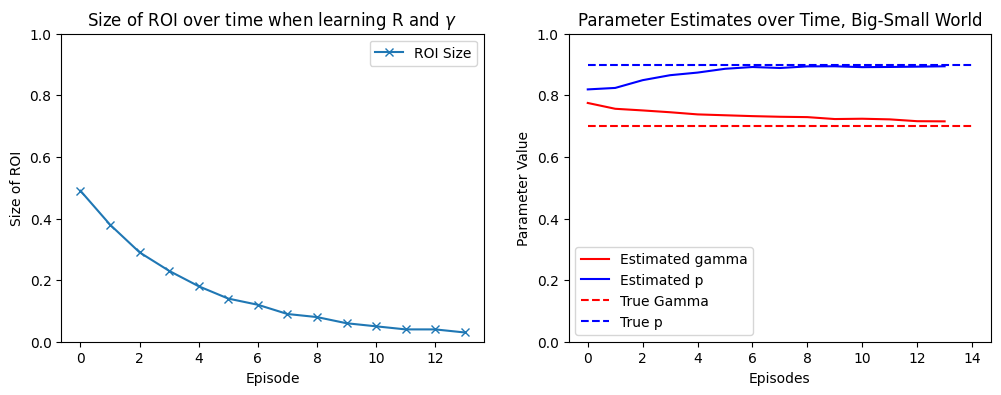

In [6]:
params = env_design.diagnostics["parameter_means"]
params = np.array(params)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

roi_sizes = env_design.diagnostics["ROI_sizes"]
roi_sizes = np.array(roi_sizes)
axs[0].plot(roi_sizes, "-x", label="ROI Size")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Size of ROI")
axs[0].set_ylim(0,1)
axs[0].legend()
axs[0].set_title("Size of ROI over time when learning R and $\gamma$")

axs[1].plot(params[:, 0], color="red", label="Estimated gamma")
axs[1].plot(params[:, 1], color="blue", label="Estimated p")
axs[1].hlines(true_params.gamma, 0, params.shape[0], color="red", linestyle="--", label="True Gamma")
axs[1].hlines(true_params.T, 0, params.shape[0], color="blue", linestyle="--", label="True p")
axs[1].set_ylim(0,1)
axs[1].set_title("Parameter Estimates over Time, Big-Small World")
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Parameter Value")
axs[1].legend()